<a href="https://colab.research.google.com/github/ReemAlsharabi/KAUST-Academy/blob/main/Adv/Day2/MNIST_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Augmentation

In most DL applications Data is one of the major bottlenecks it is not always easy to collect and lable data. We are always looking for smart ways to reduce the cost of data generation.

One way to do this data augmentaion, where we use the available data to produce more data samples.

In this example we will generate new samples of MNIST dataset using torchvision.transforms.



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader
import imageio as Image
from skimage import transform

%matplotlib inline

In [3]:
# MNIST
def mnist(batch_sz):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.RandomCrop(28, padding=4),
                        transforms.ToTensor(),
                    ])
    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])

    # Training dataset
    train_data = MNIST(root='./datasets', train=True, download=True, transform=transform_train)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz, shuffle=True,pin_memory=True)

    # Test dataset
    test_data = MNIST(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, test_loader, num_classes


In [4]:
train_loader, test_loader,_=mnist(10)

100%|██████████| 9912422/9912422 [00:00<00:00, 108162763.62it/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 46536954.98it/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25614507.45it/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 24268189.51it/s]


Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [5]:
!mkdir 'images'

In [6]:
im_name=[]
labels=[]
ind=0
for i,batch in enumerate(train_loader):
  if i>30:
      break
  for j in range(batch[0].shape[0]):
    
    im=batch[0][j,:,:,:]
    save_image(im,f"./images/{ind}.jpg",normalize=True)
    im_name.append(f"{ind}.jpg")
    labels.append(batch[1][j].item())
    ind+=1
    im=torch.squeeze(im)

    #plt.imshow(im)
    #plt.title(f"{batch[1][j].item()}")

In [7]:
import pandas as pd
df=pd.DataFrame(zip(im_name,labels),columns=['Name','label'])

df.to_csv('im_list.csv')

In [11]:
df

,Name,label
0,0.jpg,0
1,1.jpg,6
2,2.jpg,9
3,3.jpg,3
4,4.jpg,1
...,...,...
305,305.jpg,7
306,306.jpg,7
307,307.jpg,8
308,308.jpg,3


In [18]:
trans = transforms.ToTensor()
resize = transforms.Resize([32,32])
affine = transforms.RandomAffine(30)
class MyDataset(Dataset):
    def __init__(self, im_fol, csv_file, trans = None):
        super().__init__()
        self.df = pd.read_csv(csv_file)
        self.im_list = df["Name"].to_list()
        self.labels = df["label"].to_list()
        self.im_fol = im_fol
        self.trans = trans
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        im = Image.imread(f"{self.im_fol}{self.im_list[idx]}") # read an image file
        im = np.array(im)

        if self.trans:
            im = self.trans(im)

        label = self.labels[idx]
        
        #im = resize(im)
        #im = affine(im)
        
        return im,label

In [19]:
trans = transforms.Compose([transforms.ToTensor(), transforms.RandomAffine(30)])
dataset = MyDataset("images/", "im_list.csv", trans = trans)

In [20]:
dataset[0][0].shape

<ipython-input-18-4b8bc070c97a>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = Image.imread(f"{self.im_fol}{self.im_list[idx]}") # read an image file


torch.Size([3, 28, 28])

<ipython-input-18-4b8bc070c97a>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = Image.imread(f"{self.im_fol}{self.im_list[idx]}") # read an image file


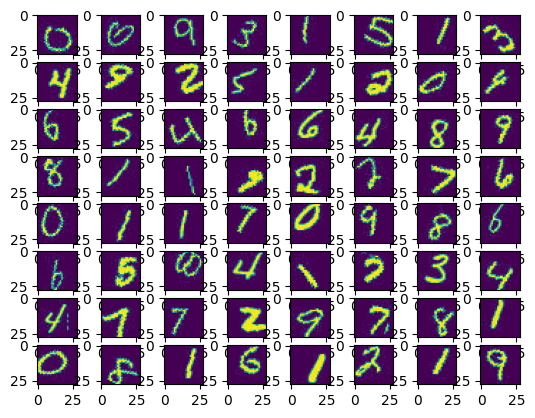

In [21]:
for i in range(64):
  plt.subplot(8, 8, i+1)
  plt.imshow(dataset[i][0][0, :, :])

In [22]:
# t --->[shift_left, shift_rigth, shift_up, shift_down]

class Translate:
    def __init__(self, t):
        self.t = t
  
    def __call__(self,im): # call function because the method has the same name as the 
    
        nch, nr, ncl = im.shape

        for i, v in enumerate (self.t):

            if i==0 and v>0: # adding at the top. Moving the image down
                shift = torch.zeros(nch, v, ncl)
                im = torch.cat((shift, im), dim=1)
                im = im[:, :nr, :ncl]

            if i==1 and v>0: # adding at the bottom. Moving the image up
                shift = torch.zeros(nch, v, ncl)
                im = torch.cat((im, shift), dim=1)
                im = im[:, v:, :ncl]

            if i==2 and v>0: # adding to the left. Moving the image to the right
                shift = torch.zeros(nch, nr, v)
                im = torch.cat((im, shift), dim=2)
                im = im[:, :nr, :ncl]

            if i==3 and v>0: # adding to the right. Moving the image to the left
                shift = torch.zeros(nch, nr, v)
                im = torch.cat((im, shift), dim=1)
                im = im[:, :nr, v:]
        return im

In [26]:
im = dataset[0][0]

<ipython-input-18-4b8bc070c97a>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = Image.imread(f"{self.im_fol}{self.im_list[idx]}") # read an image file


In [27]:
im.shape

torch.Size([3, 28, 28])

In [28]:
transform = Translate([10, 0, 15, 0])
im_t = transform(im)

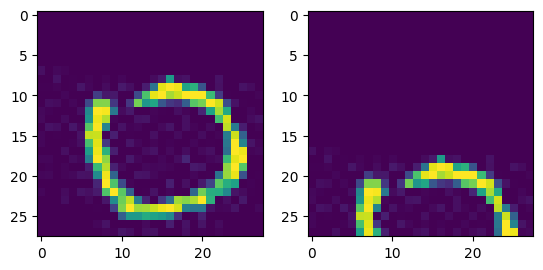

In [29]:
plt.subplot(121)
plt.imshow(im[0,:,:])

plt.subplot(122)
plt.imshow(im_t[0,:,:])